In [1]:
# 라이브러리 불러오기

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import pickle
import tensorflow_hub as hub
from tensorflow.keras.layers import LSTM

%matplotlib inline
import matplotlib.pyplot as plt

In [1061]:
# 데이터 불러오기 
data_final= pd.read_excel('C:/Users/dnjsw/Desktop/final_data.xlsx')

In [1024]:
# 구별 확진자수 확인하기 
data_final.groupby(['구'])['확진자수'].sum().reset_index().sort_values(by='확진자수')

,구,확진자수
23,중구,110
22,종로구,115
7,금천구,124
5,광진구,185
2,강북구,199
15,성동구,220
20,용산구,226
13,서대문구,257
1,강동구,273
6,구로구,275


In [1063]:
# 구별로 모델을 돌리기위해 구별로 정리된 dataframe 생성

중구 = data_final[data_final['구'] == '중구'].reset_index(drop=True)
구로구 = data_final[data_final['구'] == '구로구'].reset_index(drop=True)
서대문구 = data_final[data_final['구'] == '서대문구'].reset_index(drop=True)
성동구 = data_final[data_final['구'] == '성동구'].reset_index(drop=True)
송파구 = data_final[data_final['구'] == '송파구'].reset_index(drop=True)
용산구 = data_final[data_final['구'] == '용산구'].reset_index(drop=True)
성북구 = data_final[data_final['구'] == '성북구'].reset_index(drop=True)
영등포구 = data_final[data_final['구'] == '영등포구'].reset_index(drop=True)
동작구 = data_final[data_final['구'] == '동작구'].reset_index(drop=True)
중랑구 = data_final[data_final['구'] == '중랑구'].reset_index(drop=True)
노원구 = data_final[data_final['구'] == '노원구'].reset_index(drop=True)
양천구 = data_final[data_final['구'] == '양천구'].reset_index(drop=True)
강남구 = data_final[data_final['구'] == '강남구'].reset_index(drop=True)
강서구 = data_final[data_final['구'] == '강서구'].reset_index(drop=True)
관악구 = data_final[data_final['구'] == '관악구'].reset_index(drop=True)
강동구 = data_final[data_final['구'] == '강동구'].reset_index(drop=True)
은평구 = data_final[data_final['구'] == '은평구'].reset_index(drop=True)
마포구 = data_final[data_final['구'] == '마포구'].reset_index(drop=True)
도봉구 = data_final[data_final['구'] == '도봉구'].reset_index(drop=True)
종로구 = data_final[data_final['구'] == '종로구'].reset_index(drop=True)
서초구 = data_final[data_final['구'] == '서초구'].reset_index(drop=True)
동대문구 = data_final[data_final['구'] == '동대문구'].reset_index(drop=True)
강북구 = data_final[data_final['구'] == '강북구'].reset_index(drop=True)
광진구 = data_final[data_final['구'] == '광진구'].reset_index(drop=True)
금천구 = data_final[data_final['구'] == '금천구'].reset_index(drop=True)

# 분석할 구 설정

In [1344]:
# 분석할 구를 data로 지정한 후 data를 분석에 사용 
data = 강북구

# 전처리

In [1345]:
# 구 컬럼 삭제
del data['구']

In [1346]:
# 종속변수를 확진자수로 설정 
y_data = data.pop('확진자수')

In [1347]:
# 데이터 정규화 

data = (data - data.mean())/data_final.std()

In [1348]:
# 독립변수 설정 
x_data = data[[ '유동인구수', '코로나', '사회적거리두기', '우울', '소매점_여가시설',
       '식료품점_약국', '공원', '대중교통정거장', '직장', '주거지']].values

In [1349]:
y_data = pd.DataFrame(y_data)

In [1350]:
y_data = y_data.values

# 데이터 shape 맞추기

In [1351]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [1352]:
# Train 데이터셋 
# 2일치의 데이터를 보고 다음날의 확진자 수를 예측
x_tr, y_tr = multivariate_data(x_data, y_data, 0,258, 2, 1, 1, single_step=True)

In [1353]:
# Test 데이터셋 
x_te, y_te = multivariate_data(x_data, y_data, 258,None , 2, 1, 1, single_step=True)

In [1354]:
x_tr.shape

(256, 2, 10)

In [1355]:
y_tr.shape

(256, 1)

In [1356]:
y_tr = tf.constant(y_tr, dtype = tf.float64)
y_te = tf.constant(y_te, dtype = tf.float64)

In [1357]:
def gen():
    for i in zip(x_tr,y_tr):
        yield i

In [1358]:
m = tf.data.Dataset.from_generator(gen, output_shapes=(tf.TensorShape([None,None]),tf.TensorShape([None])), 
                                   output_types=(tf.float64, tf.float64))

In [1359]:
pad_batch = m.batch(7)

In [1360]:
next(iter(pad_batch))

(<tf.Tensor: id=12035211, shape=(7, 2, 10), dtype=float64, numpy=
 array([[[ 2.38669362e-01,  3.73618379e+00, -4.78560123e-01,
          -1.82029867e+00, -2.59298319e+00, -1.02590360e+00,
          -1.82724712e+00, -2.75210226e+00, -5.44845267e-01,
           1.78450022e+00],
         [ 1.40944983e-02,  5.07840674e+00, -4.60580808e-01,
          -1.26974185e+00, -7.84897076e-01, -4.10136708e-01,
          -7.53855329e-01, -1.02257011e+00,  4.48913143e-02,
           1.20790463e+00]],
 
        [[ 1.40944983e-02,  5.07840674e+00, -4.60580808e-01,
          -1.26974185e+00, -7.84897076e-01, -4.10136708e-01,
          -7.53855329e-01, -1.02257011e+00,  4.48913143e-02,
           1.20790463e+00],
         [-1.50673636e-03,  4.40211151e+00, -4.49837322e-01,
          -1.15342702e+00, -4.83549390e-01, -1.02590360e+00,
          -1.07587287e+00, -8.06378586e-01,  4.48913143e-02,
           9.19606836e-01]],
 
        [[-1.50673636e-03,  4.40211151e+00, -4.49837322e-01,
          -1.15342702e+

In [1361]:
def gen2():
    for i in zip(x_te,y_te):
        yield i

In [1362]:
m = tf.data.Dataset.from_generator(gen2, output_shapes=(tf.TensorShape([None,None]),tf.TensorShape([None])), 
                                   output_types=(tf.float64, tf.float64))

In [1363]:
test_pad_batch = m.batch(7)

In [1364]:
next(iter(test_pad_batch))

(<tf.Tensor: id=12035274, shape=(7, 2, 10), dtype=float64, numpy=
 array([[[ 9.41299232e-02, -6.32192123e-01, -3.31064104e-01,
           1.91947758e-01,  3.20044441e-01,  9.24024893e-01,
          -2.17159434e-01,  1.24744085e+00, -1.23604852e-01,
          -1.09847773e+00],
         [-5.78282845e-02, -3.69538858e-01, -1.46532543e-01,
           9.44116944e-01,  4.20493669e-01,  4.10885816e-01,
          -1.81379707e-01,  1.24744085e+00,  7.18875979e-01,
          -8.10179936e-01]],
 
        [[-5.78282845e-02, -3.69538858e-01, -1.46532543e-01,
           9.44116944e-01,  4.20493669e-01,  4.10885816e-01,
          -1.81379707e-01,  1.24744085e+00,  7.18875979e-01,
          -8.10179936e-01],
         [-6.12365543e-02, -4.43424507e-01, -3.09495080e-01,
           5.95172476e-01,  6.21392127e-01,  3.74554071e-04,
          -6.10736423e-01,  1.67982388e+00,  7.18875979e-01,
          -1.09847773e+00]],
 
        [[-6.12365543e-02, -4.43424507e-01, -3.09495080e-01,
           5.95172476e-

# 모델링

In [1365]:
inputs = tf.keras.layers.Input(shape=(2,10))

In [1366]:
out1 = tf.keras.layers.LSTM(64, activation = 'relu')(inputs)

In [1367]:
# out2 = tf.keras.layers.Dropout(0.5)(out1)

In [1368]:
out2 = tf.keras.layers.Dense(32)(out1)

In [1369]:
out3 = tf.keras.layers.Dense(1)(out2)

In [1370]:
model = tf.keras.Model(inputs = inputs, outputs = out3)

In [1371]:
model.compile(loss = 'mae',
             optimizer = 'adam'
             )

In [1372]:
model.summary()

Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 2, 10)]           0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 64)                19200     
_________________________________________________________________
dense_78 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 33        
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [1373]:
history = model.fit(pad_batch, epochs=300)

Epoch 1/300
37/37 [==============================] - 2s 65ms/step - loss: 0.67400.679 - 2s 80ms/step - lo
Epoch 2/300
37/37 [==============================] - 1s 14ms/step - loss: 0.6755
Epoch 3/300
37/37 [==============================] - 1s 17ms/step - loss: 0.6421
Epoch 4/300
37/37 [==============================] - 1s 15ms/step - loss: 0.6242
Epoch 5/300
37/37 [==============================] - 1s 15ms/step - loss: 0.6188
Epoch 6/300
37/37 [==============================] - 1s 15ms/step - loss: 0.6015
Epoch 7/300
37/37 [==============================] - 1s 16ms/step - loss: 0.6068
Epoch 8/300
37/37 [==============================] - 1s 16ms/step - loss: 0.5973
Epoch 9/300
37/37 [==============================] - 1s 17ms/step - loss: 0.5867
Epoch 10/300
37/37 [==============================] - 1s 17ms/step - loss: 0.5733
Epoch 11/300
37/37 [==============================] - 0s 12ms/step - loss: 0.5777
Epoch 12/300
37/37 [==============================] - 1s 16ms/step - loss: 0.5567


37/37 [==============================] - 1s 14ms/step - loss: 0.2116
Epoch 200/300
37/37 [==============================] - 1s 15ms/step - loss: 0.2156
Epoch 201/300
37/37 [==============================] - 1s 14ms/step - loss: 0.2653
Epoch 202/300
37/37 [==============================] - 1s 14ms/step - loss: 0.2043
Epoch 203/300
37/37 [==============================] - 1s 15ms/step - loss: 0.2092
Epoch 204/300
37/37 [==============================] - 1s 14ms/step - loss: 0.2285
Epoch 205/300
37/37 [==============================] - 0s 13ms/step - loss: 0.2600
Epoch 206/300
37/37 [==============================] - 0s 8ms/step - loss: 0.2016
Epoch 207/300
37/37 [==============================] - 1s 15ms/step - loss: 0.2087
Epoch 208/300
37/37 [==============================] - 1s 14ms/step - loss: 0.2276
Epoch 209/300
37/37 [==============================] - 1s 15ms/step - loss: 0.2561
Epoch 210/300
37/37 [==============================] - 1s 15ms/step - loss: 0.1930
Epoch 211/300
37/37

In [1374]:
y_pred = model.predict(x_te)
y_pred = pd.DataFrame(y_pred)

In [1375]:
y_real = y_data[261:]
y_real = pd.DataFrame(y_real)

# 실제값과 예측값 비교

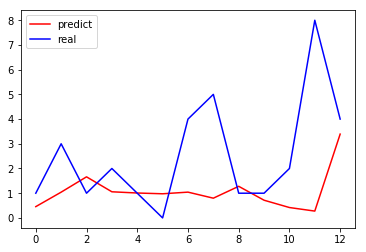

In [1376]:
plt.figure(2)
plt.plot(y_pred, 'r')
plt.plot(y_real, 'b')
plt.legend(['predict','real'])

In [1377]:
from sklearn import metrics
score = metrics.mean_absolute_error(y_real, y_pred)
print('MAE: ',score)

MAE:  1.747879615196815


In [1378]:
# 예측값과 실제값 확인 
a = pd.concat([y_pred, y_real], axis = 1)
a.columns = ['예측값','실제값']
a

,예측값,실제값
0,0.456988,1
1,1.042819,3
2,1.662462,1
3,1.057544,2
4,1.007869,1
5,0.976864,0
6,1.043435,4
7,0.798805,5
8,1.278913,1
9,0.716125,1
